# Binary Classification of Alaska Car Crashes

This notebook analyzes car crashes in Alaska, classifying them into severe (involving injury or death) and non-severe crashes.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Ensure the plot is displayed in the notebook
%matplotlib inline

## Load and Preprocess Data

Upload your CSV file to Google Colab before running this cell.

In [4]:
# Load the dataset
df = pd.read_csv('cleaned_test_data.csv')

# Create binary target variable
df['severe_crash'] = df['severity'].apply(lambda x: 1 if x in ['Fatal Injury (Killed)', 'Suspected Serious Injury'] else 0)

# Display the first few rows and basic information about the dataset
print(df.head())
print(df.info())

# Check for missing values and handle them
print("\nMissing values:")
print(df.isnull().sum())
df = df.dropna()

# Encode categorical variables
categorical_columns = ['first_harmful_event', 'units', 'crash_type', 'causal_unit_action', 'at_intersection', 'junction', 'manner_of_collision', 'weather', 'area']
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

   crash_number            severity         first_harmful_event units  \
0     100074249  No Apparent Injury  Motor Vehicle In-Transport     2   
1     100096154             Unknown                     Unknown     1   
2     100109452  No Apparent Injury                 Live Animal     2   
3     100109453     Possible Injury           Overturn/Rollover     1   
4     100109454  No Apparent Injury  Motor Vehicle In-Transport     2   

                    crash_type causal_unit_action at_intersection  \
0                      Unknown      Turning Right             Yes   
1  Single Vehicle Run-Off-Road            Unknown              No   
2               Animal-Vehicle     Going Straight              No   
3  Single Vehicle Run-Off-Road     Going Straight              No   
4               Angle - T-Bone   Starting in Road             Yes   

       junction                                manner_of_collision  weather  \
0  Intersection                                              Angle 

<ipython-input-4-d848fbac4c23>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
<ipython-input-4-d848fbac4c23>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])


## Prepare Features and Target Variable

In [6]:
# Prepare features and target variable
X = df.drop(['crash_number', 'severity', 'fatal', 'minor', 'serioues', 'severe_crash'], axis=1)
y = df['severe_crash']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original class distribution:")
print(y_train.value_counts(normalize=True))
print("\nResampled class distribution:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

Original class distribution:
severe_crash
0    0.966067
1    0.033933
Name: proportion, dtype: float64

Resampled class distribution:
severe_crash
0    0.5
1    0.5
Name: proportion, dtype: float64


## Model Training and Hyperparameter Tuning

In [7]:
# Define hyperparameter grid for tuning
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search with cross-validation
model = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best model for prediction
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 0.946308131311013


## Model Evaluation

In [8]:
# Evaluate the improved model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     11317
           1       0.14      0.60      0.22       368

    accuracy                           0.87     11685
   macro avg       0.56      0.74      0.58     11685
weighted avg       0.96      0.87      0.91     11685


Confusion Matrix:
[[9949 1368]
 [ 148  220]]

ROC AUC Score:
0.8172566953909279


## Feature Importance Visualization

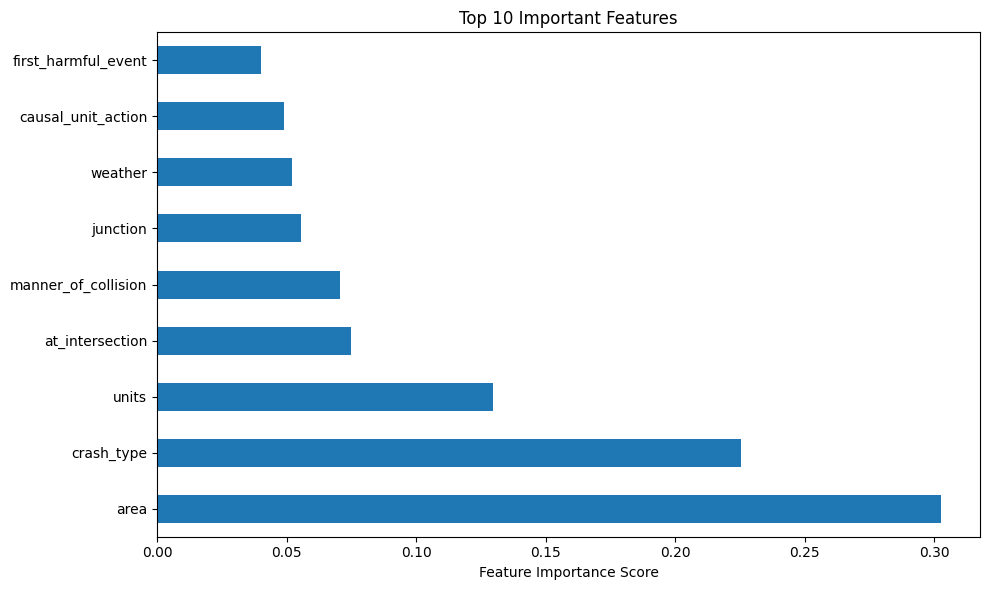

In [9]:
# Plot feature importance
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(best_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.xlabel("Feature Importance Score")
plt.tight_layout()
plt.show()

## Insights

In [10]:
print("Insights:")
print("1. The top contributing factors to severe car crashes in Alaska are:")
for i, feature in enumerate(feat_importances.nlargest(5).index, 1):
    print(f"   {i}. {feature}")

print("\n2. The model's performance can be seen in the classification report above.")
print("\n3. The confusion matrix shows the model's prediction accuracy for severe vs. non-severe crashes.")
print("\n4. SMOTE was used to balance the classes in the training data.")
print("\n5. Hyperparameter tuning found the best parameters for the XGBoost model, optimizing its performance.")
print("\n6. The ROC AUC score indicates the model's ability to distinguish between severe and non-severe crashes.")

Insights:
1. The top contributing factors to severe car crashes in Alaska are:
   1. area
   2. crash_type
   3. units
   4. at_intersection
   5. manner_of_collision

2. The model's performance can be seen in the classification report above.

3. The confusion matrix shows the model's prediction accuracy for severe vs. non-severe crashes.

4. SMOTE was used to balance the classes in the training data.

5. Hyperparameter tuning found the best parameters for the XGBoost model, optimizing its performance.

6. The ROC AUC score indicates the model's ability to distinguish between severe and non-severe crashes.
